In [1]:
import EITfunc.EITlook as eit

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic

%matplotlib inline

In [2]:
jan1_1996 = '1996-01-01T00:00:00.000Z'
jan1_1996 = astropy.time.Time(jan1_1996).jd
print(jan1_1996)

2450083.5


In [3]:
dayspermonth = [31,28,31,30,31,30,31,31,30,31,30,31,0]
months = [r'Jan',r'Feb',r'Mar',r'Apr',r'May',r'June',r'July',r'Aug',r'Sept',r'Oct',r'Nov',r'Dec','']
# all years divisible by 4 during SOHO are leap years, including 2000

01
02
03
04
05
06
07
08
09
10
11
12


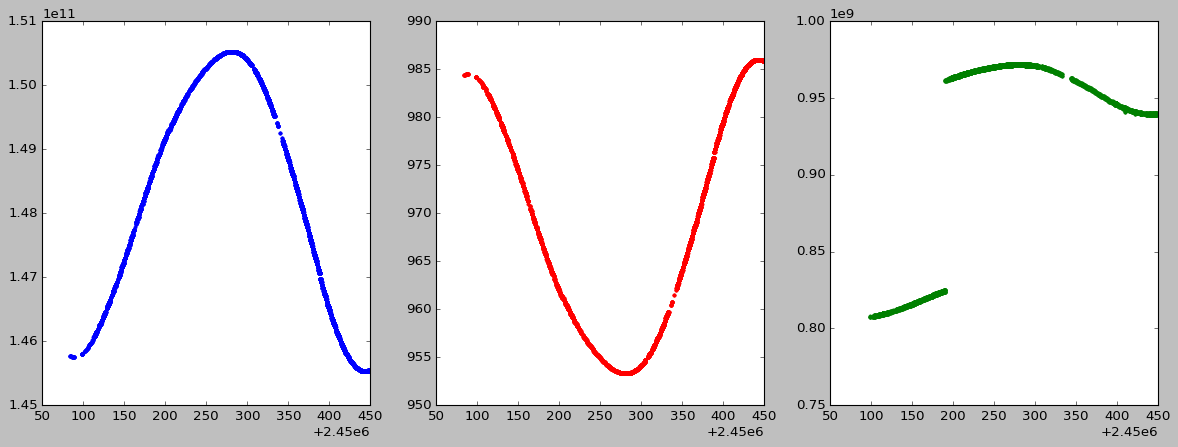

./EIT/1996/12/25/SOHO_EIT_195_19961225T121714_L1.fits
145533274325.0
./EIT/1996/01/16/SOHO_EIT_284_19960116T001337_L1.fits
807239943.1280541


In [4]:
#for year in range(1996, 2010):
for year in [1996]:
    solarDistances = []
    obsDates = []
    solarRads = []
    pixelScales = []
    fpaths = []
    physDistToEdge = []
    
    for m in range(1,13):
        month = str(m).zfill(2)
        days = sorted([int(f.path[-2:]) for f in os.scandir("./EIT/{0}/{1}/".format(year,month)) if f.is_dir()])
        print(month)
        
        for d in days:
            day = str(d).zfill(2)
            fitsFiles = os.scandir("./EIT/{0}/{1}/{2}/".format(year,month,day))
            
            for f in fitsFiles:
                hdul = fits.open(f.path)
                header = hdul[0].header
                data = hdul[0].data

                sci_obj_ = header['SCI_OBJ'].replace("/"," ").replace(" ","_").lower()

                
                solarDistances.append(header['DSUN_OBS'])
                obsDates.append(header['DATE-BEG'])
                solarRads.append(header['RSUN_OBS'])
                pixelScales.append(header['CDELT1'])
                fpaths.append(f.path)

                #find minimum physical distance from center of disk to any edge 
                xcenter, ycenter = eit.center_from_header(header)

                if "full_sun" in sci_obj_ and np.shape(data) == (1024,1024): 
                    #physical scale of each pixel in this image is:
                    thisPhysPixelScale = 2.627 * (np.pi/(3600*180.)) * header['DSUN_OBS']
    
                    pixelsToNearestEdge = np.min(np.array((xcenter, 1024-xcenter, ycenter, 1024-ycenter)))
                    physToNearestEdge = pixelsToNearestEdge * thisPhysPixelScale
    
                    physDistToEdge.append(physToNearestEdge)

                else:
                    physDistToEdge.append(0)
    
    solarDistances = np.array(solarDistances)
    solarRads = np.array(solarRads)
    pixelScales = np.array(pixelScales)
    physDistToEdge = np.array(physDistToEdge)
    fpaths = np.array(fpaths)
    
    t = astropy.time.Time(obsDates, format='isot', scale='utc').jd
    fig, axes = plt.subplots(1,3,figsize=(18,6))
    axes[0].plot(t[solarDistances>1.e11], solarDistances[solarDistances>1.e11],'b.')
    axes[1].plot(t[solarDistances>1.e11], solarRads[solarDistances>1.e11],'r.')
    axes[2].plot(t[solarDistances>1.e11], physDistToEdge[solarDistances>1.e11],'g.')
    axes[2].set_ylim(0.75e9,1.e9)
    plt.show()


    goodDistImgs = (solarDistances > 0.)
    print(fpaths[goodDistImgs][np.argmin(solarDistances[goodDistImgs])])
    print(solarDistances[goodDistImgs][np.argmin(solarDistances[goodDistImgs])])

    goodShapeImgs = (physDistToEdge > 0.)
    print(fpaths[goodShapeImgs][np.argmin(physDistToEdge[goodShapeImgs])])
    print(physDistToEdge[goodShapeImgs][np.argmin(physDistToEdge[goodShapeImgs])])
    

/Users/Emily/Documents/astro/archivalSOHO/data/EITfunc/EITfunc/EITlook.py:60: RuntimeWarning: invalid value encountered in log10
  cs = ax0.imshow(np.log10(data),cmap='Greys_r',interpolation='None',origin="lower")


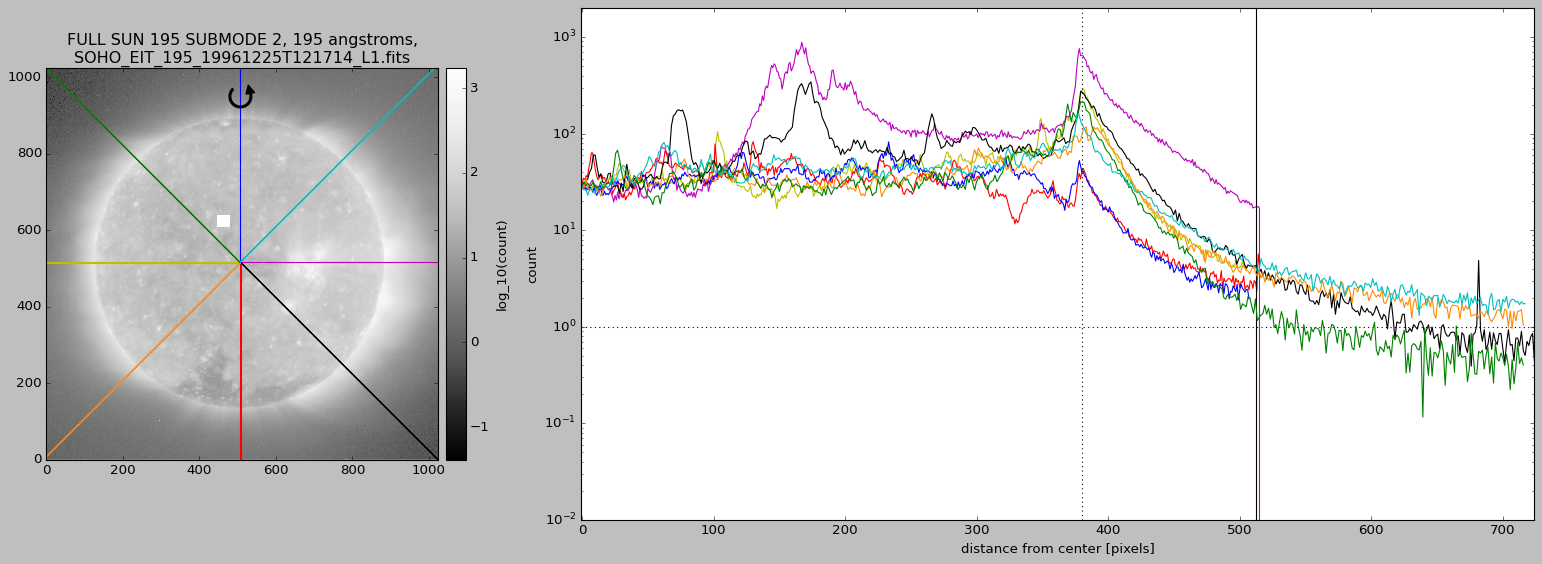

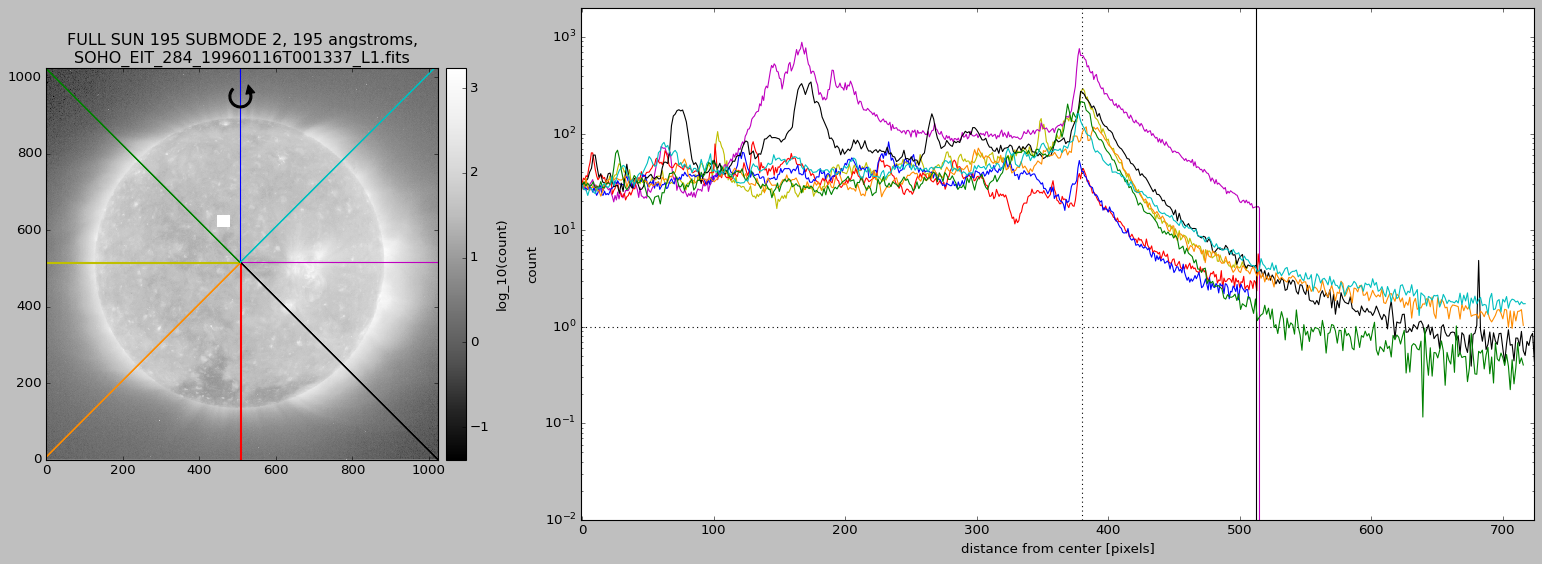

In [5]:
goodDistImgs = (solarDistances > 0.)
minDistanceFITS = fpaths[goodDistImgs][np.argmin(solarDistances[goodDistImgs])]
hdul = fits.open(minDistanceFITS)
header = hdul[0].header
data = hdul[0].data
xcenter, ycenter = eit.center_from_header(header)
xcenter = int(np.round(xcenter,0))
ycenter = int(np.round(ycenter,0))
eit.plot_full_sun_EIT(minDistanceFITS.split("/")[-1], header, data, xcenter=xcenter, ycenter=ycenter)

goodShapeImgs = (physDistToEdge > 0.)
minDistanceToEdgeFITS = fpaths[goodShapeImgs][np.argmin(physDistToEdge[goodShapeImgs])]
hdul = fits.open(minDistanceFITS)
header = hdul[0].header
data = hdul[0].data
xcenter, ycenter = eit.center_from_header(header)
xcenter = int(np.round(xcenter,0))
ycenter = int(np.round(ycenter,0))
eit.plot_full_sun_EIT(minDistanceToEdgeFITS.split("/")[-1], header, data, xcenter=xcenter, ycenter=ycenter)

#luckily this is a square image, so we'll be drawing a square box around images taken from farther away

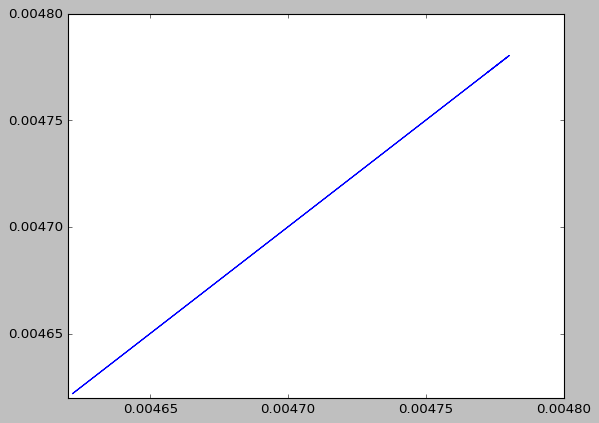

In [6]:
plt.plot(solarRads[solarDistances>1.e11] * np.pi/(3600*180.), 695699968/solarDistances[solarDistances>1.e11])

In [7]:
medianSolarDistance = np.median(solarDistances[solarDistances > 0.])
print(medianSolarDistance)
minSolarDistance = np.min(solarDistances[solarDistances > 0.])
print(minSolarDistance)

maxSolarRad = np.max(solarRads[solarDistances > 0.])
print(maxSolarRad)

minPhysDistToEdge = np.min(physDistToEdge[physDistToEdge > 0.])
print(minPhysDistToEdge)

147502379932.0
145533274325.0
986.010427668
807239943.1280541


In [13]:
#for year in range(1996, 2010):
for year in [1996]:
    jan1_thisyear = '{0}-01-01T00:00:00.000Z'.format(year)
    jan1_thisyear = astropy.time.Time(jan1_thisyear).jd
    
    obsTimes_171 = []
    obsTimes_195 = []
    obsTimes_284 = []
    obsTimes_304 = []
    obsTimes_dark = []

    fluxes_171 = []
    fluxes_195 = []
    fluxes_284 = []
    fluxes_304 = []
    medianfluxes_dark = []

    sci_objs = []
    dates = []
    fpaths = []
    for m in range(1,13):
        month = str(m).zfill(2)
        days = sorted([int(f.path[-2:]) for f in os.scandir("./EIT/{0}/{1}/".format(year,month)) if f.is_dir()])
        print(month)
        
        for d in days:
            day = str(d).zfill(2)
            fitsFiles = os.scandir("./EIT/{0}/{1}/{2}/".format(year,month,day))
            
            for f in fitsFiles:
                hdul = fits.open(f.path)
                header = hdul[0].header
                data = hdul[0].data
                
                sci_objs.append(header['SCI_OBJ'])
                dates.append(header['DATE-BEG'])
                fpaths.append(f.path)

                sci_obj_ = header['SCI_OBJ'].replace("/"," ").replace(" ","_").lower()

                #This is an extremely naive method of extracting the LC--just sum up all the flux in the image
                #and normalize by exposure time and solar distance
                    
                #pixel counts have units of DN/s already so they've already been normalized by exposure time
                #pixel count * exp time has units of DN

                #to weight by distance, want to trim the edges of all the images so that they have the same field of
                #view as the one taken closest to the Sun (where the Sun has angular radius maxSolarRad = 986.010427668arcsec)

                #exclude pathological case where solar distance is 0
                if header['DSUN_OBS'] < 1.e11:
                    continue


                #find center of solar disk
                xcenter, ycenter = eit.center_from_header(header) # pixels
                
                #minimum physical distance from center of disk to edge of image in 1996 is minPhysDistToEdge ~= 8.07e8 m

                #physical scale of each pixel in this image is:
                thisPhysPixelScale = 2.627 * (np.pi/(3600*180.)) * header['DSUN_OBS']  #meters/pixel

                # we want to trim our image into a circle of radius 8.07e8 m around (xcenter, ycenter)
                pixCutoutRadius = minPhysDistToEdge/thisPhysPixelScale # m /(m/pixel)
            
                image_idxs = np.indices((1024,1024))
                cutout_mask = ( (image_idxs[0,:,:] - ycenter)**2 + (image_idxs[1,:,:] - xcenter)**2 <= (pixCutoutRadius)**2 )
                
                if "full_sun" in sci_obj_: 
                    hist = str(header['HISTORY'])

                    # catch the one image with sci_obj_ = 'full_sun_304' which
                    # doesn't have a wavelength keyword (it seems to be a mislabeled dark image?) 
                    if "Data not calibrated" in hist:
                        continue
                        
                    wavelength = header['WAVELNTH']
                   
                    #exclude lower-resolution or partial images and images with missing data blocks
                    if np.shape(data) == (1024,1024) and header['MSBLOCKS'] == 0:
                        if wavelength == 171:
                            obsTimes_171.append(header['DATE-BEG'])
                            fluxes_171.append(np.sum(data[cutout_mask]))
                            
                        if wavelength == 195:
                            obsTimes_195.append(header['DATE-BEG'])
                            fluxes_195.append(np.sum(data[cutout_mask]))
                            
                        if wavelength == 284:
                            obsTimes_284.append(header['DATE-BEG'])
                            fluxes_284.append(np.sum(data[cutout_mask]))
                            
                        if wavelength == 304:
                            obsTimes_304.append(header['DATE-BEG'])
                            fluxes_304.append(np.sum(data[cutout_mask]))
    
                elif "dark_image" in sci_obj_:
                    #separate out what I assume are mis-labeled stray light images
                    if np.median(data) < 1000.:
                        #print(header['DATE-BEG'])
                        obsTimes_dark.append(header['DATE-BEG']) 
                        medianfluxes_dark.append(np.median(data))
    
    tDark = astropy.time.Time(obsTimes_dark, format='isot', scale='utc').jd
    t171 = astropy.time.Time(obsTimes_171, format='isot', scale='utc').jd
    t195 = astropy.time.Time(obsTimes_195, format='isot', scale='utc').jd
    t284 = astropy.time.Time(obsTimes_284, format='isot', scale='utc').jd
    t304 = astropy.time.Time(obsTimes_304, format='isot', scale='utc').jd

    f171 = np.array(fluxes_171)
    f195 = np.array(fluxes_195)
    f284 = np.array(fluxes_284)
    f304 = np.array(fluxes_304)
    mfDark = np.array(medianfluxes_dark)

    #first pass uncertainties, very rough!
    unc171 = np.sqrt(f171 + 1024*1024*np.median(mfDark))
    unc195 = np.sqrt(f195 + 1024*1024*np.median(mfDark))
    unc284 = np.sqrt(f284 + 1024*1024*np.median(mfDark))
    unc304 = np.sqrt(f304 + 1024*1024*np.median(mfDark))

01
02
03
04
05
06
07
08
09
10
11
12


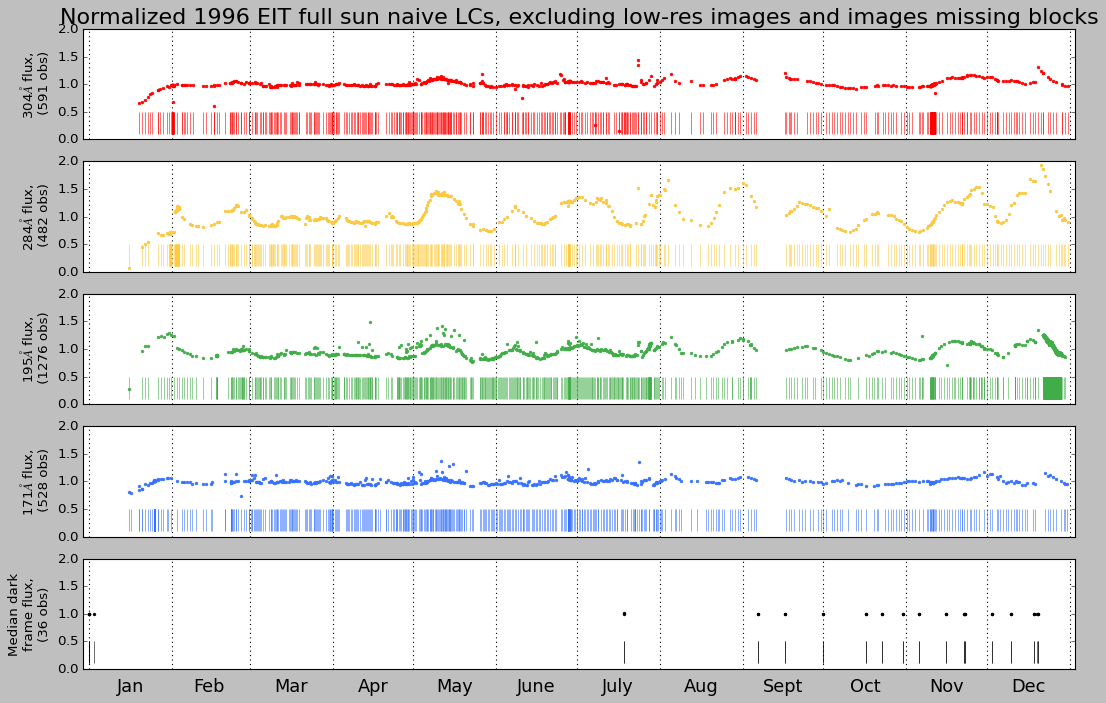

In [64]:
fig, axes = plt.subplots(5,1,figsize=(16,10))

runningdaycount = 0
for i, d in enumerate(dayspermonth):
    for ax in axes:
        ax.axvline(runningdaycount,color='k',ls=':')    
    axes[4].text(runningdaycount + d/2, -0.4, months[i],horizontalalignment='center',fontsize=16)
    runningdaycount = runningdaycount+d
    # leap years
    if year%4 == 0 and i==1:
        runningdaycount = runningdaycount + 1
    
axes[4].errorbar(tDark-jan1_thisyear, mfDark/np.median(mfDark), ls='None',marker='.',ms=5,c='k')
axes[3].errorbar(t171-jan1_thisyear, f171/np.median(f171), yerr=unc171/np.median(f171), ls='None', elinewidth=1, capsize=0, marker='.',ms=5,c='#3772ff',ecolor='k')
axes[2].errorbar(t195-jan1_thisyear, f195/np.median(f195), yerr=unc195/np.median(f195), ls='None', elinewidth=1, capsize=0, marker='.',ms=5,c='#41ad49',ecolor='k')
axes[1].errorbar(t284-jan1_thisyear, f284/np.median(f284), yerr=unc284/np.median(f284), ls='None', elinewidth=1, capsize=0, marker='.',ms=5,c='#fdca40',ecolor='k')
axes[0].errorbar(t304-jan1_thisyear, f304/np.median(f304), yerr=unc304/np.median(f304), ls='None', elinewidth=1, capsize=0, marker='.',ms=5,c='r',ecolor='k')
#ax.set_xlabel('time', fontsize=16) #("BJD-2450083.5 [days since 01/01/{0} 00:00 UTC]".format(year),fontsize=16)


axes[4].plot(tDark-jan1_thisyear, 0.3*np.ones_like(tDark), ls='None',marker='|',ms=20,mec='k')
axes[3].plot(t171-jan1_thisyear,  0.3*np.ones_like(t171), ls='None',   marker='|',ms=20,mec='#3772ff')
axes[2].plot(t195-jan1_thisyear,  0.3*np.ones_like(t195), ls='None', marker='|',ms=20,mec='#41ad49')
axes[1].plot(t284-jan1_thisyear,  0.3*np.ones_like(t284), ls='None', marker='|',ms=20,mec='#fdca40')
axes[0].plot(t304-jan1_thisyear,  0.3*np.ones_like(t304), ls='None', marker='|',ms=20,mec='r')


axes[4].set_ylabel("Median dark""\n""frame flux,""\n""({0} obs)".format(len(tDark)))
axes[3].set_ylabel(r"171$\AA$ flux,""\n"" ({0} obs)".format(len(t171)))
axes[2].set_ylabel(r"195$\AA$ flux,""\n"" ({0} obs)".format(len(t195)))
axes[1].set_ylabel(r"284$\AA$ flux,""\n"" ({0} obs)".format(len(t284)))
axes[0].set_ylabel(r"304$\AA$ flux,""\n"" ({0} obs)".format(len(t304)))


for ax in axes:
    ax.set_xticks([])
    ax.set_xlim(-2,runningdaycount+2)
    #ax.axhline(1,ls=":",color='k',zorder=1,lw=0.5)
    ax.ticklabel_format(scilimits=(-4,4),useMathText=True)
    ax.set_ylim(0.,2)

    
axes[0].set_title(r'Normalized {0} EIT full sun naive LCs, excluding low-res images and images missing blocks'.format(year),fontsize=20)
#plt.show()
plt.savefig("./EITnaiveLCs_{0}.pdf".format(year), bbox_inches="tight")